# Exploring FNA Image Dataset to Identify and Predict Breast Cancer
##### Daniella Raz
##### October 14, 2018

---
## Table of contents
1. [Purpose](#Purpose)
2. [About the Data](#About)
3. [Data Exploration and Data Preparation](#Data)
    1. [Loading and Cleaning Data](#Loading)
    2. [Preliminary Visualizations](#Preliminary)
    2. [Correlations](#Correlations)
    3. [Examining Benign Versus Malignant Masses](#Examining)
    4. [Distributions](#Distributions)
    5. [Standardizing Data](#Standardizing)
    6. [Data Exploration Summary](#Summary)
4. [Predictive Modeling](#Predictive)
    1. [Dimension Reduction - Principal Component Analysis](#Dimension)
    2. [Logistic Regression](#Logistic)

---

## I. Purpose <a name="Purpose"></a>
> In this notebook, I visualize and analyze the data retrieved from breast masses removed during biopsy. My goal is to build a model that can identify malignant vs benign tumors based on the breast mass features included in the dataset. As I lack training in oncology and tumor biology, my analytic approach is entirely data-driven, with a narrow aim of identifying variables that maximize classification according to the expert diagnostic decisions.

---
## II. About the Data <a name="About"></a>
> Dataset can be found here courtesy of the University of Wisconsin: 

> https://www.kaggle.com/uciml/breast-cancer-wisconsin-data

> This dataset contains variables that represent features extracted from digitized images of biopsy (fine needle aspirate, FNA) of a breast mass, and diagnostic decision on malignancy of the mass - malignant vs benign. "All feature values are recoded with four significant digits." The following are the features that have been extracted from each mass image:

> - radius (mean of distances from center to points on the perimeter) 
- texture (standard deviation of gray-scale values) 
- perimeter 
- area 
- smoothness (local variation in radius lengths) 
- compactness (perimeter^2 / area - 1.0) 
- concavity (severity of concave portions of the contour) 
- concave points (number of concave portions of the contour) 
- symmetry 
- fractal dimension ("coastline approximation" - 1) 

---

## III. Data Exploration and Data Cleaning <a name="Data"></a>

In [239]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from scipy import stats
import statsmodels.api as sm
from statsmodels.stats.outliers_influence import variance_inflation_factor
import warnings
warnings.filterwarnings('ignore')
import re
from sklearn.model_selection import train_test_split

%matplotlib inline

#### **a. Loading and Cleaning Data:** <a name="Loading"></a>

In [240]:
# load & view data, dropping id
bc_data = pd.read_csv('data.csv')
bc_data = bc_data.drop(['id', 'Unnamed: 32'], axis = 1)
bc_data.head(5)

,diagnosis,radius_mean,texture_mean,perimeter_mean,area_mean,smoothness_mean,compactness_mean,concavity_mean,concave points_mean,symmetry_mean,...,radius_worst,texture_worst,perimeter_worst,area_worst,smoothness_worst,compactness_worst,concavity_worst,concave points_worst,symmetry_worst,fractal_dimension_worst
0,M,17.99,10.38,122.80,1001.0,0.11840,0.27760,0.3001,0.14710,0.2419,...,25.38,17.33,184.60,2019.0,0.1622,0.6656,0.7119,0.2654,0.4601,0.11890
1,M,20.57,17.77,132.90,1326.0,0.08474,0.07864,0.0869,0.07017,0.1812,...,24.99,23.41,158.80,1956.0,0.1238,0.1866,0.2416,0.1860,0.2750,0.08902
2,M,19.69,21.25,130.00,1203.0,0.10960,0.15990,0.1974,0.12790,0.2069,...,23.57,25.53,152.50,1709.0,0.1444,0.4245,0.4504,0.2430,0.3613,0.08758
3,M,11.42,20.38,77.58,386.1,0.14250,0.28390,0.2414,0.10520,0.2597,...,14.91,26.50,98.87,567.7,0.2098,0.8663,0.6869,0.2575,0.6638,0.17300
4,M,20.29,14.34,135.10,1297.0,0.10030,0.13280,0.1980,0.10430,0.1809,...,22.54,16.67,152.20,1575.0,0.1374,0.2050,0.4000,0.1625,0.2364,0.07678


In [241]:
# number of rows, columns
bc_data.shape

(569, 31)

In [242]:
# checking datatypes, diagnosis will need to be converted to 1s and 0s
bc_data.dtypes

diagnosis                   object
radius_mean                float64
texture_mean               float64
perimeter_mean             float64
area_mean                  float64
smoothness_mean            float64
compactness_mean           float64
concavity_mean             float64
concave points_mean        float64
symmetry_mean              float64
fractal_dimension_mean     float64
radius_se                  float64
texture_se                 float64
perimeter_se               float64
area_se                    float64
smoothness_se              float64
compactness_se             float64
concavity_se               float64
concave points_se          float64
symmetry_se                float64
fractal_dimension_se       float64
radius_worst               float64
texture_worst              float64
perimeter_worst            float64
area_worst                 float64
smoothness_worst           float64
compactness_worst          float64
concavity_worst            float64
concave points_worst

In [243]:
# converting diagnosis to numeric
bc_data['diagnosis'] = np.where(bc_data['diagnosis']=='M', 1, 0)

In [244]:
# sanity check
bc_data.head(5)

,diagnosis,radius_mean,texture_mean,perimeter_mean,area_mean,smoothness_mean,compactness_mean,concavity_mean,concave points_mean,symmetry_mean,...,radius_worst,texture_worst,perimeter_worst,area_worst,smoothness_worst,compactness_worst,concavity_worst,concave points_worst,symmetry_worst,fractal_dimension_worst
0,1,17.99,10.38,122.80,1001.0,0.11840,0.27760,0.3001,0.14710,0.2419,...,25.38,17.33,184.60,2019.0,0.1622,0.6656,0.7119,0.2654,0.4601,0.11890
1,1,20.57,17.77,132.90,1326.0,0.08474,0.07864,0.0869,0.07017,0.1812,...,24.99,23.41,158.80,1956.0,0.1238,0.1866,0.2416,0.1860,0.2750,0.08902
2,1,19.69,21.25,130.00,1203.0,0.10960,0.15990,0.1974,0.12790,0.2069,...,23.57,25.53,152.50,1709.0,0.1444,0.4245,0.4504,0.2430,0.3613,0.08758
3,1,11.42,20.38,77.58,386.1,0.14250,0.28390,0.2414,0.10520,0.2597,...,14.91,26.50,98.87,567.7,0.2098,0.8663,0.6869,0.2575,0.6638,0.17300
4,1,20.29,14.34,135.10,1297.0,0.10030,0.13280,0.1980,0.10430,0.1809,...,22.54,16.67,152.20,1575.0,0.1374,0.2050,0.4000,0.1625,0.2364,0.07678


In [245]:
# sanity check, are there both 1s and 0s?
bc_data['diagnosis'].unique()

array([1, 0])

In [246]:
# checking presence of any null values
bc_data.isnull().values.any()

False

#### **b. Preliminary Visualizations:** <a name="Preliminary"></a>

> Intuitively, it makes sense that the size of a mass would have some correlation with diagnosis. This section examines some preliminary scatterplots comparing radius_mean (a reflection of tumor size) with other characteristics to identify some initial trends that might prove relevant once examined more rigorously.

> Figure 1.1 shows that generally malignant tumors seem to have a larger radius than do benign ones. However, tumor texture varies widely within benign and malignant tumors. Such between-group and within-group variation suggests that texture is a noisy variable and likely an unsuitable classifier.

> Figure 1.2 shows that generally benign masses are concentrated in the lower left corner - meaning benign masses have a smaller mean radius and smaller value for mean compactness. In the extreme high values for both radius_mean, as shown in figure 1.1, and for compactness_mean the majority of masses are malignant. Initially, it seems that looking at at compactness_mean could provide some insight into the diagnosis of the mass. The combination of both a high value for compactness_mean and radius_mean seems to point to a malignant tumor. 

> Figure 1.3 shows that the combination of both a large radius and a high value for concavity_mean points to a malignant tumor. The benign masses primarily exhibit a concavity_mean value of less than 0.1. Concavity_mean might also be useful to determine the diagnosis.

In [335]:
# ensuring that legend displays benign and malignant, not 1 and 0, and consistency of colors
bc_data['Diagnosis'] = bc_data['diagnosis'].map({0: 'Benign', 1: 'Malignant'})

Text(0.5,1,'Figure 1.1')

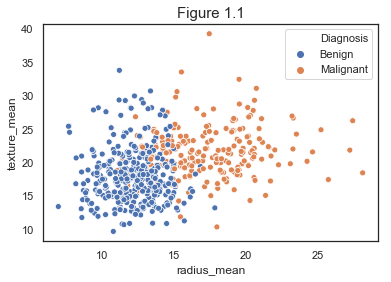

In [336]:
# exploring how radius_mean, texture_mean correspond to diagnosis
sns.scatterplot(x="radius_mean", y="texture_mean", hue="Diagnosis", data=bc_data, hue_order = ["Benign", "Malignant"])
ax = plt.gca()
ax.set_title("Figure 1.1", fontsize= 15)

Text(0.5,1,'Figure 1.2')

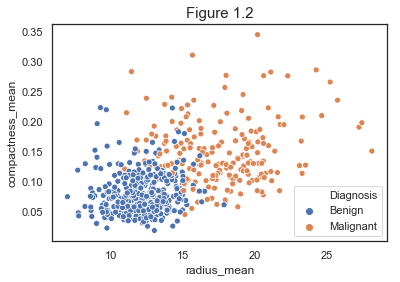

In [337]:
# exploring how radius_mean, compactness_mean correspond to diagnosis
sns.scatterplot(x="radius_mean", y="compactness_mean", hue="Diagnosis", data=bc_data, hue_order = ["Benign", "Malignant"])
ax = plt.gca()
ax.set_title("Figure 1.2", fontsize = 15)

Text(0.5,1,'Figure 1.3')

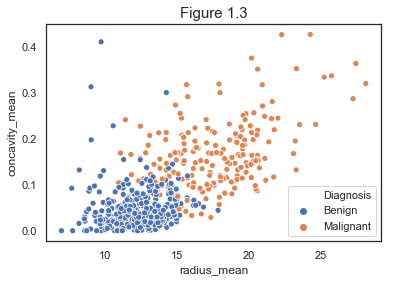

In [338]:
# exploring how radius_mean, concavity_mean correspond to diagnosis
sns.scatterplot(x="radius_mean", y="concavity_mean", hue="Diagnosis", data=bc_data, hue_order = ["Benign", "Malignant"])
ax = plt.gca()
ax.set_title("Figure 1.3", fontsize = 15)

#### **c. Correlations:** <a name="Correlations"></a>

> Highly correlated features are not only redundant, but can influence Principal Component Analysis and other dimension reduction techniques by leading to an overemphasis of the variance accounted for by correlated variables. Thus, in this section, I determine which features are highly correlated, allowing me to retain only one of the correlated features, and thus reducing the number of relevant features.  

> The correlation plot shows that radius, area, and perimeter for all 3 categories found in the data (worst, se, and mean categories) have a very high correlation. Mathematically, this correlation is straightforward given that area, perimeter, and radius are highly related measurements. Retaining all three measurements in later predictive modeling is redundant. Thus, of the three measurements I only retain area_mean, area_worst, and area_se.

> Other highly correlated (≥ 0.9) features are concave_points_mean and concavity_mean (0.92), texture_worst and texture_mean (0.91), area_worst and area_mean (0.96), as well as concave_points_worst and concave_points_mean (0.91). I will retain concavity_mean, area_mean, concave_points_mean and texture_mean. 

Text(0.5,1,'Figure 2.1 Correlation Heatmap')

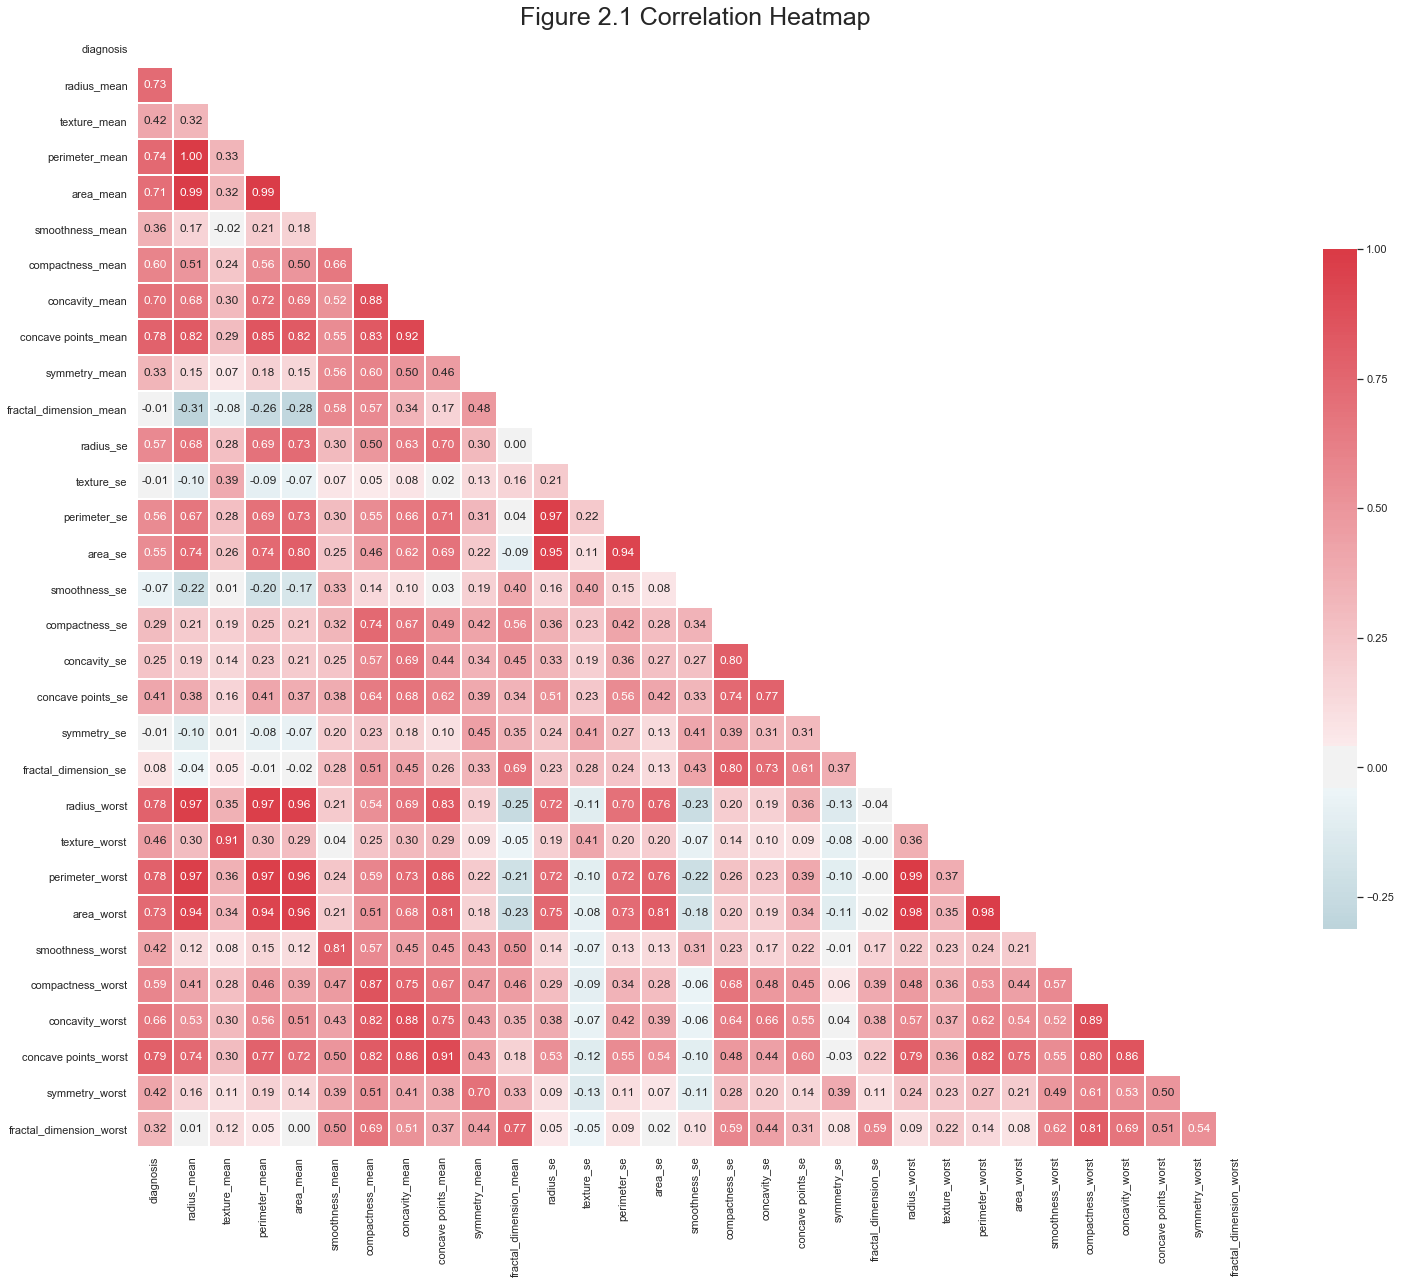

In [339]:
# source: https://seaborn.pydata.org/examples/many_pairwise_correlations.html

sns.set(style="white")
bc_data_corr = bc_data.corr()

# generate a mask for the upper triangle
mask = np.zeros_like(bc_data_corr, dtype=np.bool)
mask[np.triu_indices_from(mask)] = True

f, ax = plt.subplots(figsize=(25, 25))

# generate a custom diverging colormap
cmap = sns.diverging_palette(220, 10, as_cmap=True)

# draw the heatmap with the mask and correct aspect ratio
sns.heatmap(bc_data_corr, mask=mask, cmap=cmap, center=0,
            square=True, linewidths=.5, cbar_kws={"shrink": .5}, annot = True, fmt='.2f')

ax.set_title("Figure 2.1 Correlation Heatmap", fontsize= 25)

In [340]:
all_features = list(bc_data)
all_features = [x for x in all_features if x != 'Diagnosis']

In [341]:
# dropping perimeter and radius features, keeping area features, due to high correlation
regex = re.compile(r'perimeter|radius|texture_worst|area_worst|concave_points_worst|concave points_mean')
features = [x for x in all_features if not regex.search(x)]

In [342]:
# sanity check
features

['diagnosis',
 'texture_mean',
 'area_mean',
 'smoothness_mean',
 'compactness_mean',
 'concavity_mean',
 'symmetry_mean',
 'fractal_dimension_mean',
 'texture_se',
 'area_se',
 'smoothness_se',
 'compactness_se',
 'concavity_se',
 'concave points_se',
 'symmetry_se',
 'fractal_dimension_se',
 'smoothness_worst',
 'compactness_worst',
 'concavity_worst',
 'concave points_worst',
 'symmetry_worst',
 'fractal_dimension_worst']

In [343]:
# removing the selected highly correlated features from bc_data
bc_data_no_corr = bc_data[features]

In [344]:
bc_data_no_corr.head(5)

,diagnosis,texture_mean,area_mean,smoothness_mean,compactness_mean,concavity_mean,symmetry_mean,fractal_dimension_mean,texture_se,area_se,...,concavity_se,concave points_se,symmetry_se,fractal_dimension_se,smoothness_worst,compactness_worst,concavity_worst,concave points_worst,symmetry_worst,fractal_dimension_worst
0,1,10.38,1001.0,0.11840,0.27760,0.3001,0.2419,0.07871,0.9053,153.40,...,0.05373,0.01587,0.03003,0.006193,0.1622,0.6656,0.7119,0.2654,0.4601,0.11890
1,1,17.77,1326.0,0.08474,0.07864,0.0869,0.1812,0.05667,0.7339,74.08,...,0.01860,0.01340,0.01389,0.003532,0.1238,0.1866,0.2416,0.1860,0.2750,0.08902
2,1,21.25,1203.0,0.10960,0.15990,0.1974,0.2069,0.05999,0.7869,94.03,...,0.03832,0.02058,0.02250,0.004571,0.1444,0.4245,0.4504,0.2430,0.3613,0.08758
3,1,20.38,386.1,0.14250,0.28390,0.2414,0.2597,0.09744,1.1560,27.23,...,0.05661,0.01867,0.05963,0.009208,0.2098,0.8663,0.6869,0.2575,0.6638,0.17300
4,1,14.34,1297.0,0.10030,0.13280,0.1980,0.1809,0.05883,0.7813,94.44,...,0.05688,0.01885,0.01756,0.005115,0.1374,0.2050,0.4000,0.1625,0.2364,0.07678


#### **d. Examining Benign versus Malignant Masses:** <a name="Examining"></a>

> At first glance, there are some notable differences between malignant and benign masses. First, the mean area of malignant mass is over two times larger than it is for benign masses. Concavity_mean is about 4 times larger for malignant tumor masses than it is for benign ones. Compactness_mean 

> Mean values for features relating to smoothness, fractal_dimension and texture are quite similar across malignant and benign tumors. Given that the mean is quite sensitive to outliers, this similarity in values suggests that the outliers present in each of these features are not too influential. Looking at median for these features (fractal_dimension and texture), we again see that the values are quite similar for both malignant and benign masses.  

> For symmetry_worst and 

In [257]:
# describes data for malignant breast masses 
malignant_data = bc_data_no_corr.loc[bc_data_no_corr['diagnosis'] == 1]
malignant_data.describe()

,diagnosis,texture_mean,area_mean,smoothness_mean,compactness_mean,concavity_mean,symmetry_mean,fractal_dimension_mean,texture_se,area_se,...,concavity_se,concave points_se,symmetry_se,fractal_dimension_se,smoothness_worst,compactness_worst,concavity_worst,concave points_worst,symmetry_worst,fractal_dimension_worst
count,212.0,212.000000,212.000000,212.000000,212.000000,212.000000,212.000000,212.000000,212.000000,212.000000,...,212.000000,212.000000,212.000000,212.000000,212.000000,212.000000,212.000000,212.000000,212.000000,212.000000
mean,1.0,21.604906,978.376415,0.102898,0.145188,0.160775,0.192909,0.062680,1.210915,72.672406,...,0.041824,0.015060,0.020472,0.004062,0.144845,0.374824,0.450606,0.182237,0.323468,0.091530
std,0.0,3.779470,367.937978,0.012608,0.053987,0.075019,0.027638,0.007573,0.483178,61.355268,...,0.021603,0.005517,0.010065,0.002041,0.021870,0.170372,0.181507,0.046308,0.074685,0.021553
min,1.0,10.380000,361.600000,0.073710,0.046050,0.023980,0.130800,0.049960,0.362100,13.990000,...,0.011010,0.005174,0.007882,0.001087,0.088220,0.051310,0.023980,0.028990,0.156500,0.055040
25%,1.0,19.327500,705.300000,0.094010,0.109600,0.109525,0.174050,0.056598,0.892825,35.762500,...,0.026998,0.011415,0.014615,0.002688,0.130475,0.244475,0.326425,0.152750,0.276500,0.076302
50%,1.0,21.460000,932.000000,0.102200,0.132350,0.151350,0.189900,0.061575,1.102500,58.455000,...,0.037125,0.014205,0.017700,0.003739,0.143450,0.356350,0.404900,0.182000,0.310300,0.087600
75%,1.0,23.765000,1203.750000,0.110925,0.172400,0.203050,0.209850,0.067075,1.429250,94.000000,...,0.050443,0.017497,0.022132,0.004892,0.155975,0.447850,0.556175,0.210675,0.359225,0.102625
max,1.0,39.280000,2501.000000,0.144700,0.345400,0.426800,0.304000,0.097440,3.568000,542.200000,...,0.143800,0.040900,0.078950,0.012840,0.222600,1.058000,1.170000,0.291000,0.663800,0.207500


In [258]:
# describes data for benign breast masses
benign_data = bc_data_no_corr.loc[bc_data_no_corr['diagnosis'] == 0]
benign_data.describe()

,diagnosis,texture_mean,area_mean,smoothness_mean,compactness_mean,concavity_mean,symmetry_mean,fractal_dimension_mean,texture_se,area_se,...,concavity_se,concave points_se,symmetry_se,fractal_dimension_se,smoothness_worst,compactness_worst,concavity_worst,concave points_worst,symmetry_worst,fractal_dimension_worst
count,357.0,357.000000,357.000000,357.000000,357.000000,357.000000,357.000000,357.000000,357.00000,357.000000,...,357.000000,357.000000,357.000000,357.000000,357.000000,357.000000,357.000000,357.000000,357.000000,357.000000
mean,0.0,17.914762,462.790196,0.092478,0.080085,0.046058,0.174186,0.062867,1.22038,21.135148,...,0.025997,0.009858,0.020584,0.003636,0.124959,0.182673,0.166238,0.074444,0.270246,0.079442
std,0.0,3.995125,134.287118,0.013446,0.033750,0.043442,0.024807,0.006747,0.58918,8.843472,...,0.032918,0.005709,0.006999,0.002938,0.020013,0.092180,0.140368,0.035797,0.041745,0.013804
min,0.0,9.710000,143.500000,0.052630,0.019380,0.000000,0.106000,0.051850,0.36020,6.802000,...,0.000000,0.000000,0.009539,0.000895,0.071170,0.027290,0.000000,0.000000,0.156600,0.055210
25%,0.0,15.150000,378.200000,0.083060,0.055620,0.020310,0.158000,0.058530,0.79590,15.260000,...,0.010990,0.006433,0.015600,0.002074,0.110400,0.112000,0.077080,0.051040,0.240600,0.070090
50%,0.0,17.390000,458.400000,0.090760,0.075290,0.037090,0.171400,0.061540,1.10800,19.630000,...,0.018400,0.009061,0.019090,0.002808,0.125400,0.169800,0.141200,0.074310,0.268700,0.077120
75%,0.0,19.760000,551.100000,0.100700,0.097550,0.059990,0.189000,0.065760,1.49200,25.030000,...,0.030560,0.011870,0.024060,0.004174,0.137600,0.230200,0.221600,0.097490,0.298300,0.085410
max,0.0,33.810000,992.100000,0.163400,0.223900,0.410800,0.274300,0.095750,4.88500,77.110000,...,0.396000,0.052790,0.061460,0.029840,0.200600,0.584900,1.252000,0.175000,0.422800,0.148600


#### **e. Distributions and Outliers:** <a name="Distributions"></a>

> In addition narrowing down features by examining correlations and retaining only one in a highly correlated pair of variables, other methods for paring down the number of features to only those relevant includes 

> I drop both texture_worst and texture_mean, because tumor texture shows great variation within malignant and benign tumors, suggesting it to be an unsuitable classifier. Given that texture_se is not highly correlated with texture_mean and thus seems to represent a distinct feature of tumor masses I keep this feature.

>Here are a few observations based on the distribution plots:
- radius, texture, perimeter, area, concavity (average & average points) appear to be mostly distinct based on the diagnosis 
- smoothness, compactness, symmetry, fractal appear to have significant overlap regardless of diagnosis 

In [259]:
def multiplePlots(feature_name, n):
    # plot set up, sizing, title, padding
    fig, axs = plt.subplots(1, 2, sharey = False)
    plt.tight_layout(w_pad=6)
    fig.subplots_adjust(top=0.85)
    fig.suptitle('Figure 2.'+str(n)+': Distribution of ' + feature_name + ' variable', fontsize=15)
    
    # histogram for benign
    axs[0].set_title('Histogram for Benign vs. Malignant')
    sns.distplot(benign_data[feature], ax=axs[0], label="benign")
    # histogram for malignant
    sns.distplot(malignant_data[feature], ax=axs[0], label="malignant")
    axs[0].legend()
    
    # QQ plot for benign
    axs[1].set_title('QQ Plot for Benign vs. Malignant')
    qntls, xr = stats.probplot(benign_data[feature], fit=False)
    sns.regplot(xr,qntls, ax=axs[1], label="benign")
    # QQ plot for malignant
    qntls2, xr2 = stats.probplot(malignant_data[feature], fit=False)
    sns.regplot(xr2,qntls2, ax=axs[1], label="malignant")
    axs[1].legend()

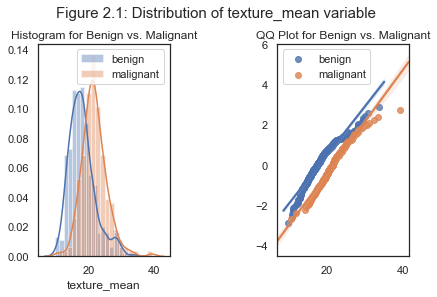

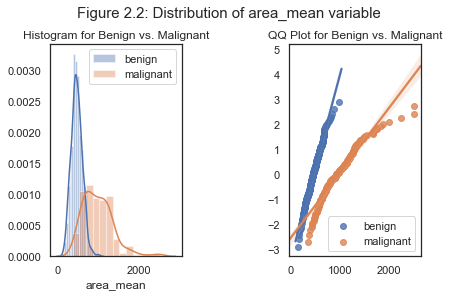

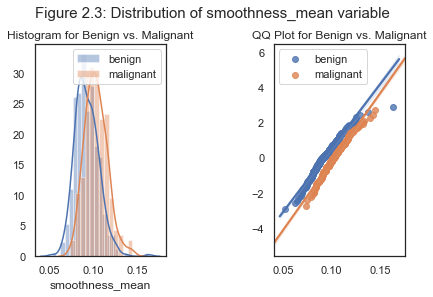

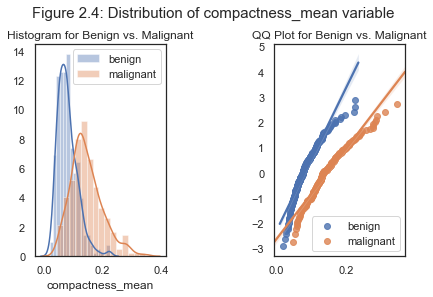

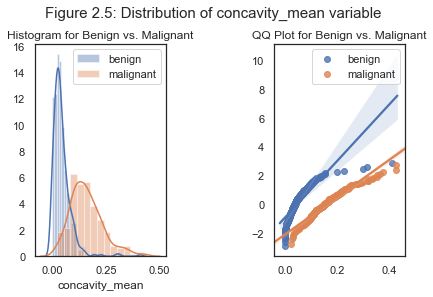

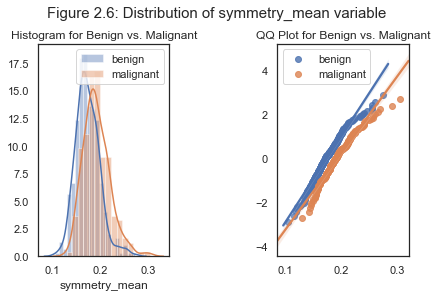

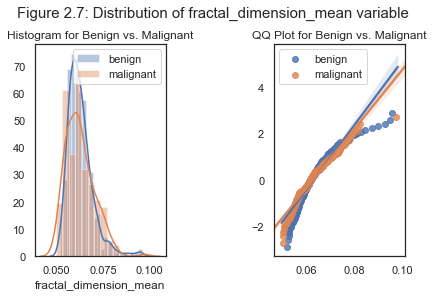

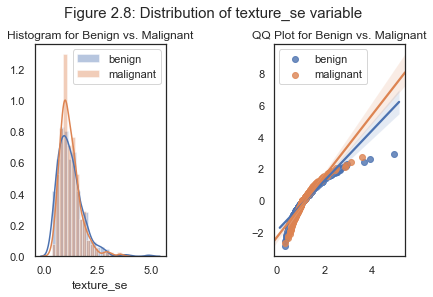

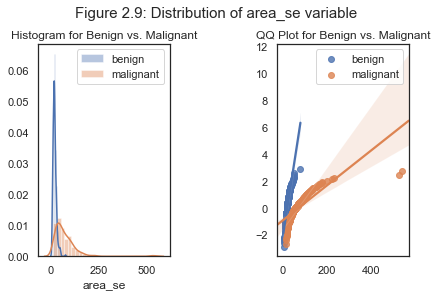

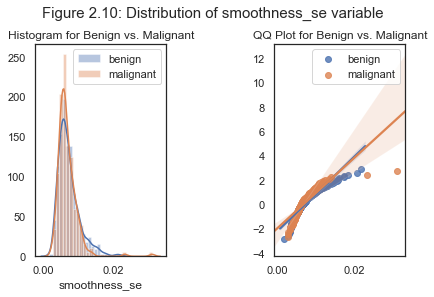

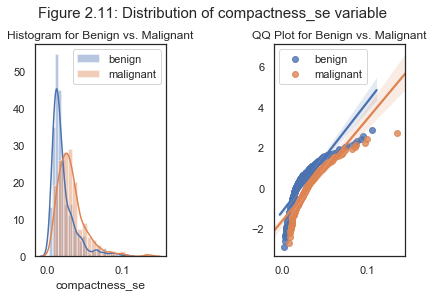

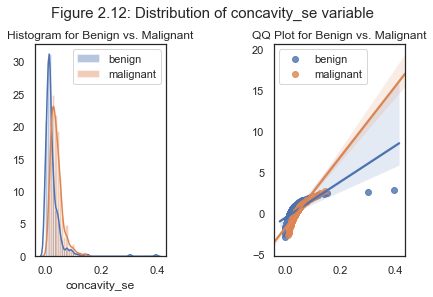

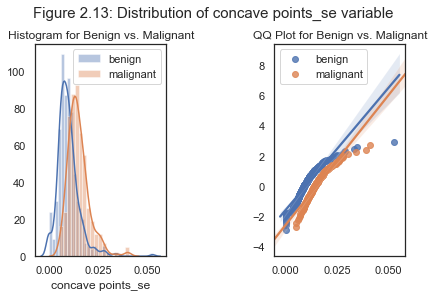

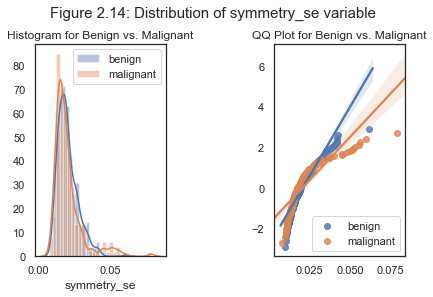

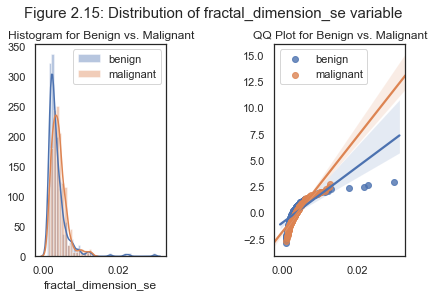

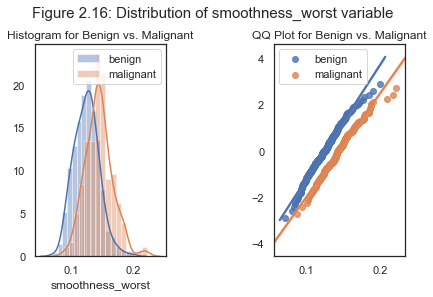

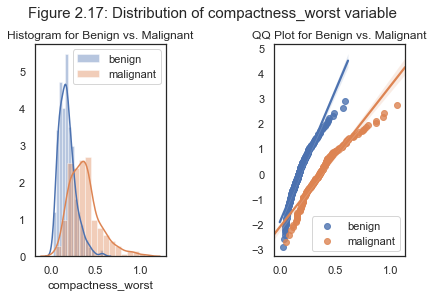

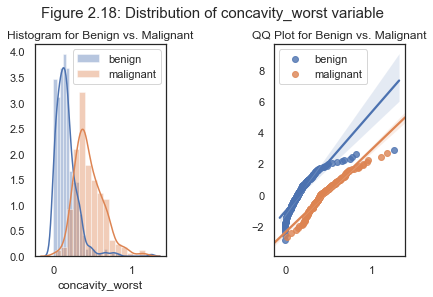

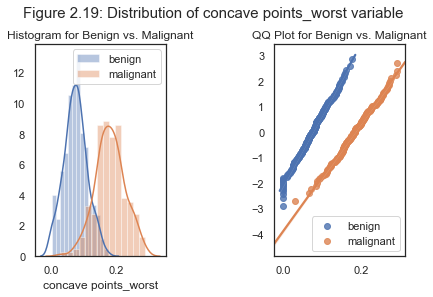

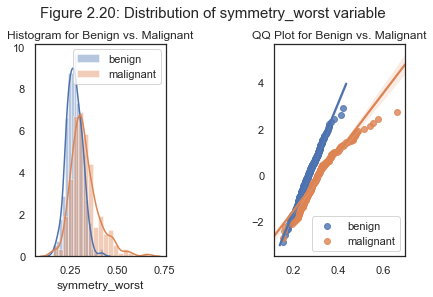

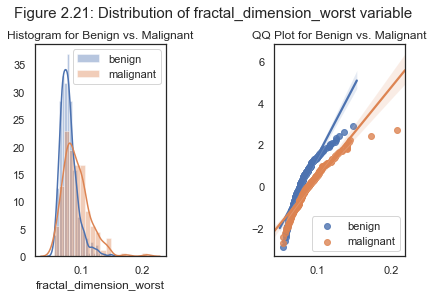

In [260]:
# plotting distributions plots (histogram and qqplot) of all variables for both benign and malignant
n = 1
for feature in features[1:]:
    multiplePlots(feature, n)
    n += 1

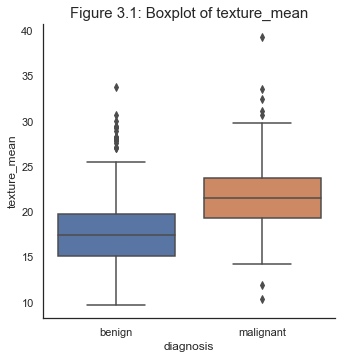

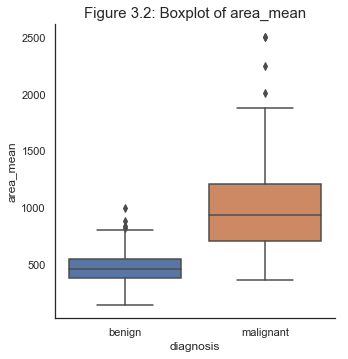

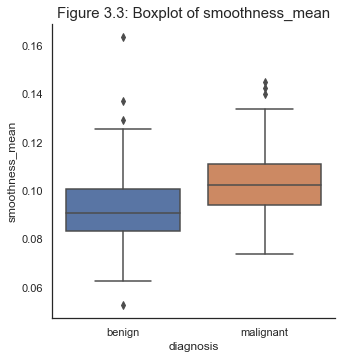

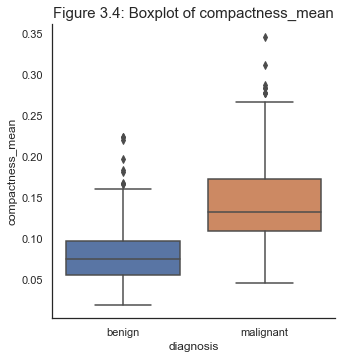

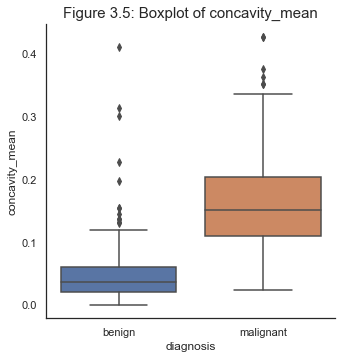

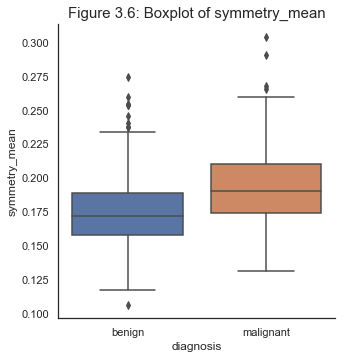

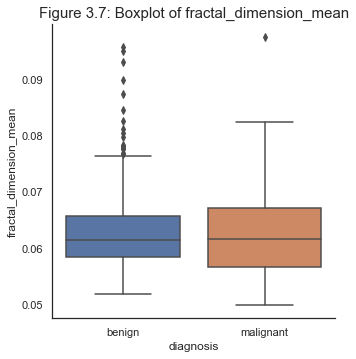

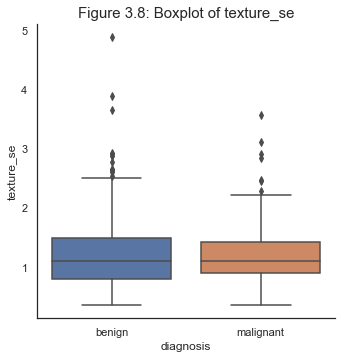

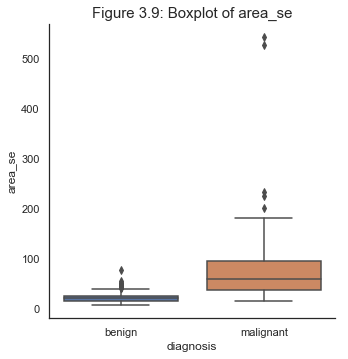

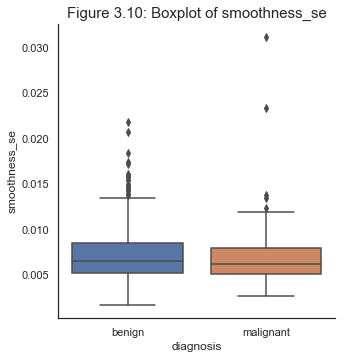

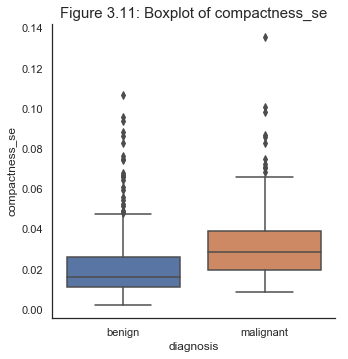

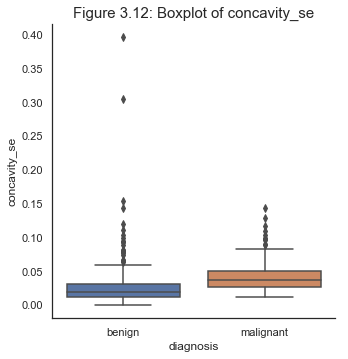

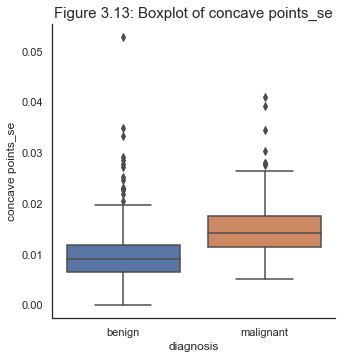

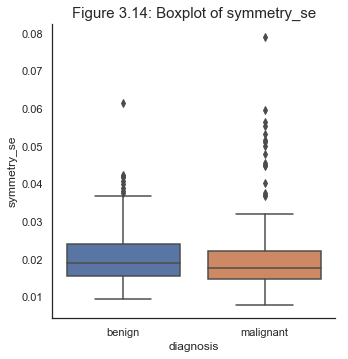

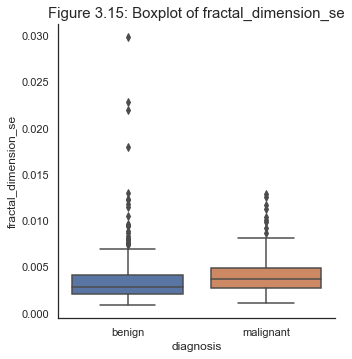

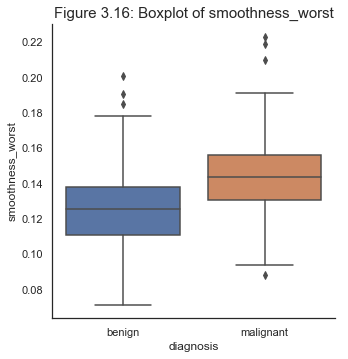

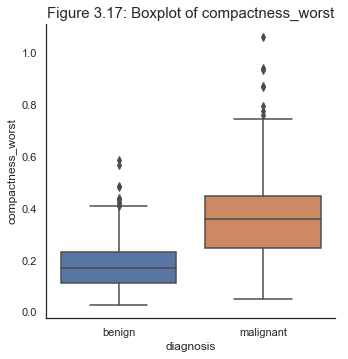

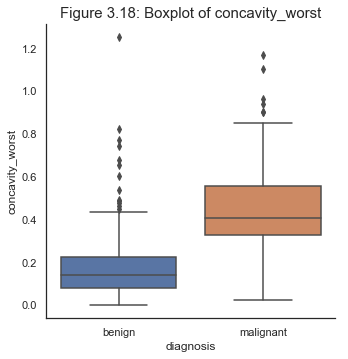

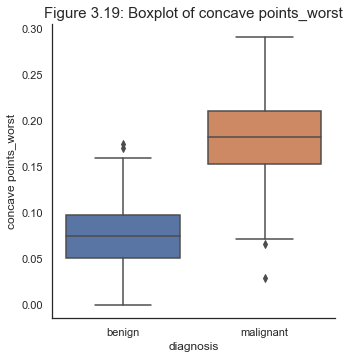

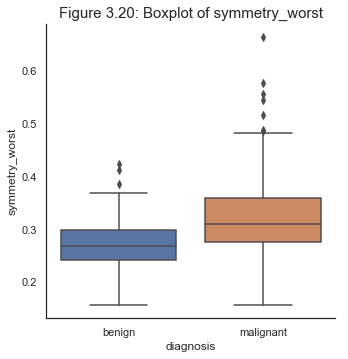

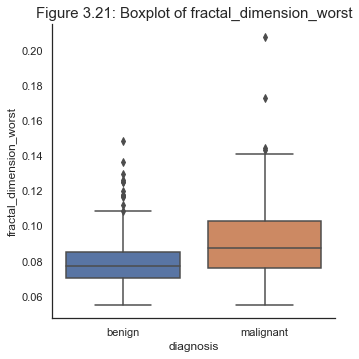

In [182]:
figure_count = 1
for feature in features[1:]:
    g = sns.catplot(x="diagnosis", y=feature, data=bc_data_no_corr, kind="box", height=5, aspect=1, legend = True).set_xticklabels(["benign", "malignant"])
    ax = plt.gca()
    ax.set_title("Figure 3."+str(figure_count) + ": Boxplot of " + feature, fontsize = 15)
    figure_count += 1

#### **f. Standardizing Data** <a name="Standardizing"></a>

> Given the range found in the variables, to avoid giving a greater weight to variables with a larger range, I standardize the data. This will also be critical for dimension reduction in later steps.

In [261]:
from sklearn.preprocessing import StandardScaler

# extract features & targets from original dataframe 
feature_data = bc_data_no_corr[features[1:]]
target_data = bc_data_no_corr[['diagnosis']]

# sanity check
feature_data.head(5)

,texture_mean,area_mean,smoothness_mean,compactness_mean,concavity_mean,symmetry_mean,fractal_dimension_mean,texture_se,area_se,smoothness_se,...,concavity_se,concave points_se,symmetry_se,fractal_dimension_se,smoothness_worst,compactness_worst,concavity_worst,concave points_worst,symmetry_worst,fractal_dimension_worst
0,10.38,1001.0,0.11840,0.27760,0.3001,0.2419,0.07871,0.9053,153.40,0.006399,...,0.05373,0.01587,0.03003,0.006193,0.1622,0.6656,0.7119,0.2654,0.4601,0.11890
1,17.77,1326.0,0.08474,0.07864,0.0869,0.1812,0.05667,0.7339,74.08,0.005225,...,0.01860,0.01340,0.01389,0.003532,0.1238,0.1866,0.2416,0.1860,0.2750,0.08902
2,21.25,1203.0,0.10960,0.15990,0.1974,0.2069,0.05999,0.7869,94.03,0.006150,...,0.03832,0.02058,0.02250,0.004571,0.1444,0.4245,0.4504,0.2430,0.3613,0.08758
3,20.38,386.1,0.14250,0.28390,0.2414,0.2597,0.09744,1.1560,27.23,0.009110,...,0.05661,0.01867,0.05963,0.009208,0.2098,0.8663,0.6869,0.2575,0.6638,0.17300
4,14.34,1297.0,0.10030,0.13280,0.1980,0.1809,0.05883,0.7813,94.44,0.011490,...,0.05688,0.01885,0.01756,0.005115,0.1374,0.2050,0.4000,0.1625,0.2364,0.07678


In [262]:
# sanity check
target_data.head(5)

,diagnosis
0,1
1,1
2,1
3,1
4,1


In [263]:
# sanity check, are there both 1s and 0s?
target_data['diagnosis'].unique()

array([1, 0])

In [264]:
# standardize the features
processed_feature_data = pd.DataFrame(StandardScaler().fit_transform(feature_data), columns=features[1:])
# sanity check
processed_feature_data.head(5)

,texture_mean,area_mean,smoothness_mean,compactness_mean,concavity_mean,symmetry_mean,fractal_dimension_mean,texture_se,area_se,smoothness_se,...,concavity_se,concave points_se,symmetry_se,fractal_dimension_se,smoothness_worst,compactness_worst,concavity_worst,concave points_worst,symmetry_worst,fractal_dimension_worst
0,-2.073335,0.984375,1.568466,3.283515,2.652874,2.217515,2.255747,-0.565265,2.487578,-0.214002,...,0.724026,0.660820,1.148757,0.907083,1.307686,2.616665,2.109526,2.296076,2.750622,1.937015
1,-0.353632,1.908708,-0.826962,-0.487072,-0.023846,0.001392,-0.868652,-0.876244,0.742402,-0.605351,...,-0.440780,0.260162,-0.805450,-0.099444,-0.375612,-0.430444,-0.146749,1.087084,-0.243890,0.281190
2,0.456187,1.558884,0.942210,1.052926,1.363478,0.939685,-0.398008,-0.780083,1.181336,-0.297005,...,0.213076,1.424827,0.237036,0.293559,0.527407,1.082932,0.854974,1.955000,1.152255,0.201391
3,0.253732,-0.764464,3.283553,3.402909,1.915897,2.867383,4.910919,-0.110409,-0.288378,0.689702,...,0.819518,1.115007,4.732680,2.047511,3.394275,3.893397,1.989588,2.175786,6.046041,4.935010
4,-1.151816,1.826229,0.280372,0.539340,1.371011,-0.009560,-0.562450,-0.790244,1.190357,1.483067,...,0.828471,1.144205,-0.361092,0.499328,0.220556,-0.313395,0.613179,0.729259,-0.868353,-0.397100


In [265]:
processed_feature_data.describe()

,texture_mean,area_mean,smoothness_mean,compactness_mean,concavity_mean,symmetry_mean,fractal_dimension_mean,texture_se,area_se,smoothness_se,...,concavity_se,concave points_se,symmetry_se,fractal_dimension_se,smoothness_worst,compactness_worst,concavity_worst,concave points_worst,symmetry_worst,fractal_dimension_worst
count,5.690000e+02,5.690000e+02,5.690000e+02,5.690000e+02,5.690000e+02,5.690000e+02,5.690000e+02,5.690000e+02,5.690000e+02,5.690000e+02,...,5.690000e+02,5.690000e+02,5.690000e+02,5.690000e+02,5.690000e+02,5.690000e+02,5.690000e+02,5.690000e+02,5.690000e+02,5.690000e+02
mean,1.049736e-16,-1.900452e-16,1.490704e-16,2.544342e-16,-1.338511e-16,2.081912e-16,5.408679e-16,-9.912009e-17,-1.088760e-16,4.426014e-16,...,1.678017e-16,2.185325e-17,1.523874e-16,-5.658430e-17,-2.189227e-16,-2.579464e-16,1.143393e-16,2.829215e-16,1.670212e-16,2.321908e-16
std,1.000880e+00,1.000880e+00,1.000880e+00,1.000880e+00,1.000880e+00,1.000880e+00,1.000880e+00,1.000880e+00,1.000880e+00,1.000880e+00,...,1.000880e+00,1.000880e+00,1.000880e+00,1.000880e+00,1.000880e+00,1.000880e+00,1.000880e+00,1.000880e+00,1.000880e+00,1.000880e+00
min,-2.229249e+00,-1.454443e+00,-3.112085e+00,-1.610136e+00,-1.114873e+00,-2.744117e+00,-1.819865e+00,-1.554264e+00,-7.378291e-01,-1.776065e+00,...,-1.057501e+00,-1.913447e+00,-1.532890e+00,-1.096968e+00,-2.682695e+00,-1.443878e+00,-1.305831e+00,-1.745063e+00,-2.160960e+00,-1.601839e+00
25%,-7.259631e-01,-6.671955e-01,-7.109628e-01,-7.470860e-01,-7.437479e-01,-7.032397e-01,-7.226392e-01,-6.948092e-01,-4.947542e-01,-6.240183e-01,...,-5.571612e-01,-6.744900e-01,-6.516807e-01,-5.851185e-01,-6.912304e-01,-6.810833e-01,-7.565142e-01,-7.563999e-01,-6.418637e-01,-6.919118e-01
50%,-1.046362e-01,-2.951869e-01,-3.489108e-02,-2.219405e-01,-3.422399e-01,-7.162650e-02,-1.782793e-01,-1.974976e-01,-3.477828e-01,-2.203352e-01,...,-1.990654e-01,-1.404958e-01,-2.194304e-01,-2.299405e-01,-4.684277e-02,-2.695009e-01,-2.182321e-01,-2.234689e-01,-1.274095e-01,-2.164441e-01
75%,5.841756e-01,3.635073e-01,6.361990e-01,4.938569e-01,5.260619e-01,5.307792e-01,4.709834e-01,4.665523e-01,1.067726e-01,3.683553e-01,...,3.367521e-01,4.726567e-01,3.556925e-01,2.886421e-01,5.975448e-01,5.396688e-01,5.311411e-01,7.125100e-01,4.501382e-01,4.507624e-01
max,4.651889e+00,5.250529e+00,4.770911e+00,4.568425e+00,4.243589e+00,4.484751e+00,4.910919e+00,6.655279e+00,1.104184e+01,8.029999e+00,...,1.207268e+01,6.649601e+00,7.071917e+00,9.851593e+00,3.955374e+00,5.112877e+00,4.700669e+00,2.685877e+00,6.046041e+00,6.846856e+00


#### **g. Data Exploration Summary:** <a name="Summary"></a>

> Data exploration 

> preliminary visualizations, correlations, examining benign versus malignant masses, checking distributions and outliers, standardizing the data. Prepared data for predictive modeling. 

---

## IV. Predictive Modeling <a name="Predictive"></a>

#### **a. Dimension Reduction - PCA:** <a name="Dimension"></a>

> <font color="magenta">NEED TO FINISH INTERPRETATION</font>

> In order to determine the point at which the marginal advantage of an additional component (meaning the additional amount of variance it explains) drops off, I construct a scree plot. Looking at the scree plot it seems to be around 2 or 3 components.

> Checking first for the variance accounted for by 3 components, it is clear that the third principal component does not explain enough variance in the data (<0.08%), thus it seems reasonable to keep just 2 principal components. The two components together account for 79.9% of the data. 

> Exploring what variables load on each component in order to determine

> Reducing the data from 21 dimensions to 'n' dimensions.

>Overall, we can say that approximately 75% of the information in this dataset can be explained by 'p1' and 'p2'. Now, 80% is ok, but let's see if there is a better explanation of the data with fewer features. Looking at the distribution plots from before, I remove the features that had significant overlap with each other in the malignant and benign samples and apply PCA again. Here are the features I remove:
- smoothness
- compactness
- symmetry
- fractal 

##### By removing the features that had similar characteristics regardless of diagnosis (smoothness, compactness, symmetry, and fractal), and then creating components based on the remaining feature, it is now possible to explain 90% of the information through dimension 1 and dimension 2, which means that these features primarily determine whether a sample is malignant or benign:

- texture (standard deviation of gray-scale values) 
- area 
- concavity (severity of concave portions of the contour) 
- concave points (number of concave portions of the contour)

Therefore, when building a logistic model to predict whether a given sample is malignant or benign, these would be the criteria the model should evaluate.

In [266]:
from sklearn.decomposition import PCA
import sklearn.decomposition as skd

<function matplotlib.pyplot.show(*args, **kw)>

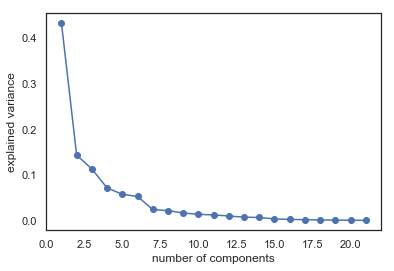

In [267]:
pca_model = skd.PCA().fit(processed_feature_data)
plt.plot(range(1,22),pca_model.explained_variance_ratio_,'b-o')
plt.xlabel('number of components') 
plt.ylabel('explained variance') 
plt.show

In [268]:
pca = PCA(n_components=8)
principal_components = pca.fit_transform(processed_feature_data)
#pca.explained_variance_ratio_

total_variance = np.sum(pca.explained_variance_ratio_)*100
print("These %d eigenvectors account for a total of %d percent of the total variance in the original dataset"
      % (n_components, total_variance))

These 8 eigenvectors account for a total of 91 percent of the total variance in the original dataset


In [269]:
def pca_results(data, pca):
    
    # Dimension indexing
    dimensions = ['Dimension {}'.format(i) for i in range(1,len(pca.components_)+1)]
    
    # PCA components
    components = pd.DataFrame(np.round(pca.components_, 4), columns = processed_feature_data.keys()) 
    components.index = dimensions

    # PCA explained variance
    ratios = pca.explained_variance_ratio_.reshape(len(pca.components_), 1) 
    variance_ratios = pd.DataFrame(np.round(ratios, 4), columns = ['Explained Variance']) 
    variance_ratios.index = dimensions

    # Create a bar plot visualization
    fig, ax = plt.subplots(figsize = (12,12))

    # Plot the feature weights as a function of the components
    components.plot(ax = ax, kind = 'bar')
    ax.set_ylabel("Feature Weights")     

    ax.set_xticklabels(dimensions, rotation=0)

    # Placing legend outside of plot
    ax.legend(loc='center left', bbox_to_anchor=(1, 0.5))
    
    # Display the explained variance ratios# 
    ax.text(2.9, 0.82, 'Explained Variance', fontsize=12)

    for i, ev in enumerate(pca.explained_variance_ratio_): 
        ax.text(i-0.20, ax.get_ylim()[1] + 0.01, "%.4f"%(ev))

    # Return a concatenated DataFrame
    return pd.concat([variance_ratios, components], axis = 1)

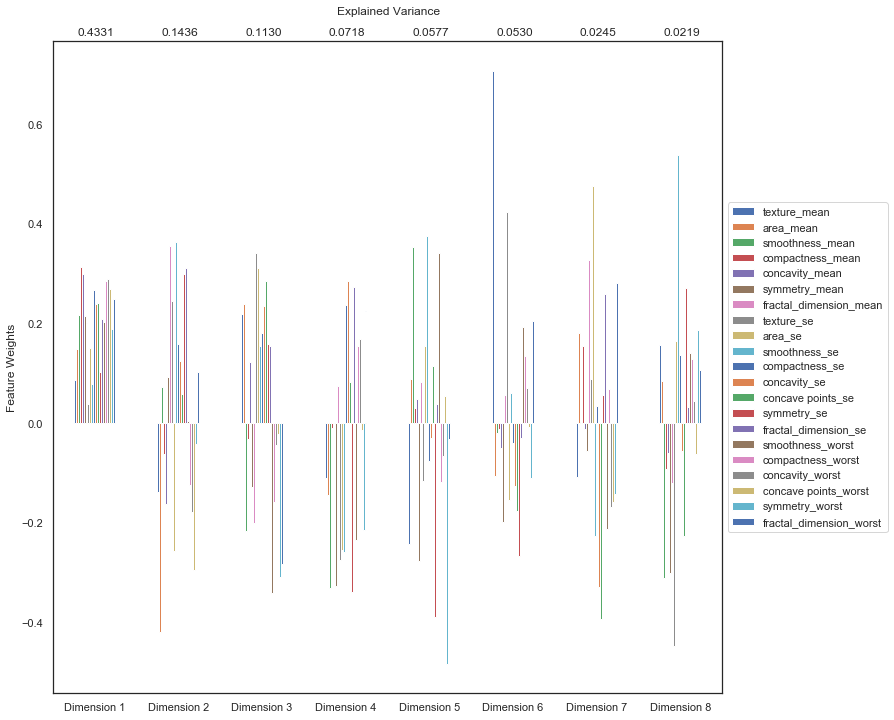

In [270]:
pca_results = pca_results(processed_feature_data, pca)

In [271]:
reduced_data = pd.DataFrame(principal_components, columns = ['Dimension 1', 'Dimension 2', 'Dimension 3', 'Dimension 4', 'Dimension 5',
                                                             'Dimension 6', 'Dimension 7', 'Dimension 8'])

In [272]:
reduced_data.head(5)

,Dimension 1,Dimension 2,Dimension 3,Dimension 4,Dimension 5,Dimension 6,Dimension 7,Dimension 8
0,7.633944,-0.813638,-2.001179,-0.734249,-0.398084,-2.478846,1.876371,-0.052606
1,-0.490262,-2.335602,0.460427,0.258345,0.365334,-0.812896,0.400690,0.153434
2,3.617095,-2.075833,0.263323,-0.606440,-0.115471,-0.857264,-0.344197,0.099926
3,11.329391,3.761996,-5.166235,-1.807510,-3.170175,-0.263959,1.089811,1.472411
4,1.553098,-1.079655,1.564738,-0.073463,2.222192,-1.719425,-0.385701,0.549450


In [273]:
final_df = pd.concat([reduced_data, bc_data_no_corr[['diagnosis']]], axis = 1)
final_df.head(5)

,Dimension 1,Dimension 2,Dimension 3,Dimension 4,Dimension 5,Dimension 6,Dimension 7,Dimension 8,diagnosis
0,7.633944,-0.813638,-2.001179,-0.734249,-0.398084,-2.478846,1.876371,-0.052606,1
1,-0.490262,-2.335602,0.460427,0.258345,0.365334,-0.812896,0.400690,0.153434,1
2,3.617095,-2.075833,0.263323,-0.606440,-0.115471,-0.857264,-0.344197,0.099926,1
3,11.329391,3.761996,-5.166235,-1.807510,-3.170175,-0.263959,1.089811,1.472411,1
4,1.553098,-1.079655,1.564738,-0.073463,2.222192,-1.719425,-0.385701,0.549450,1


#### **b. Logistic Regression:** <a name="Logistic"></a>

In [311]:
from sklearn.model_selection import train_test_split
from sklearn import linear_model
from sklearn.metrics import accuracy_score
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix

In [312]:
# selecting the target variable (diagnosis)
y = final_df.diagnosis

In [313]:
# splitting into test and train 
X_train, X_test, y_train, y_test = train_test_split(final_df, y, test_size=0.5, random_state = 0)
print("Training dataset features size:", X_train.shape, "\nTraining target size:",  y_train.shape)
print("Test dataset features size:", X_test.shape, "\nTest target size:", y_test.shape)

Training dataset features size: (284, 9) 
Training target size: (284,)
Test dataset features size: (285, 9) 
Test target size: (285,)


In [329]:
model = LogisticRegression(C=0.05)
model.fit(X_train, y_train)

LogisticRegression(C=0.05, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='ovr', n_jobs=1,
          penalty='l2', random_state=None, solver='liblinear', tol=0.0001,
          verbose=0, warm_start=False)

In [334]:
predictions = model.predict(X_test)
print(accuracy_score(y_test, predictions))
print(confusion_matrix(y_test, predictions))
print(classification_report(y_test, predictions))

0.9614035087719298
[[181   3]
 [  8  93]]
             precision    recall  f1-score   support

          0       0.96      0.98      0.97       184
          1       0.97      0.92      0.94       101

avg / total       0.96      0.96      0.96       285



In [333]:
print(confusion_matrix(y_test, predictions))

[[181   3]
 [  8  93]]
